In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

<h1> Downloading SQuAD dataset </h1>


In [ ]:
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

--2024-05-09 17:41:47--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squad/train-v2.0.json’

squad/train-v2.0.js 100%[===================>]  40.17M   120MB/s    in 0.3s    

2024-05-09 17:41:47 (120 MB/s) - ‘squad/train-v2.0.json’ saved [42123633/42123633]

--2024-05-09 17:41:47--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘squad/dev-v2.0.json’

squ

In [ ]:
!pip install transformers


<h1>EDA</h1>


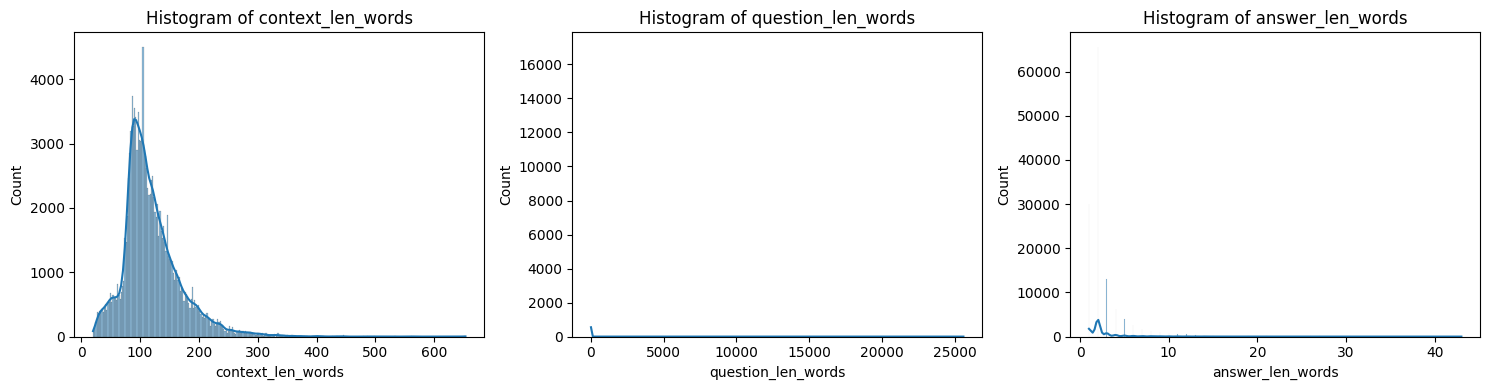

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON data
with open('squad/train-v2.0.json') as file:
    train_data = json.load(file)

# Extracting data into a DataFrame
data = []
for article in train_data['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            if 'answers' in qa and qa['answers']:
                answer = qa['answers'][0]['text']
            else:
                answer = 'No Answer'
            data.append({'context': context, 'question': question, 'answer': answer})

df = pd.DataFrame(data)

# Calculating word lengths
df['context_len_words'] = df['context'].apply(lambda x: len(str(x).split(' ')))
df['question_len_words'] = df['question'].apply(lambda x: len(str(x).split(' ')))
df['answer_len_words'] = df['answer'].apply(lambda x: len(str(x).split(' ')))

# Plotting
cols = ['context_len_words', 'question_len_words', 'answer_len_words']
plt.figure(figsize=(15, 4))
count = 0
for c in cols:
    plt.subplot(1, 3, count + 1)
    plt.title(f'Histogram of {c}')
    sns.histplot(df[c], kde=True)
    count += 1
plt.tight_layout()
plt.show()


In [ ]:
# Basic statistics
print("Total number of contexts:", df['context'].nunique())
print("Total number of questions:", df['question'].nunique())
print("Average number of questions per context:", df.groupby('context')['question'].count().mean())

Total number of contexts: 19029
Total number of questions: 130217
Average number of questions per context: 6.848441851910242


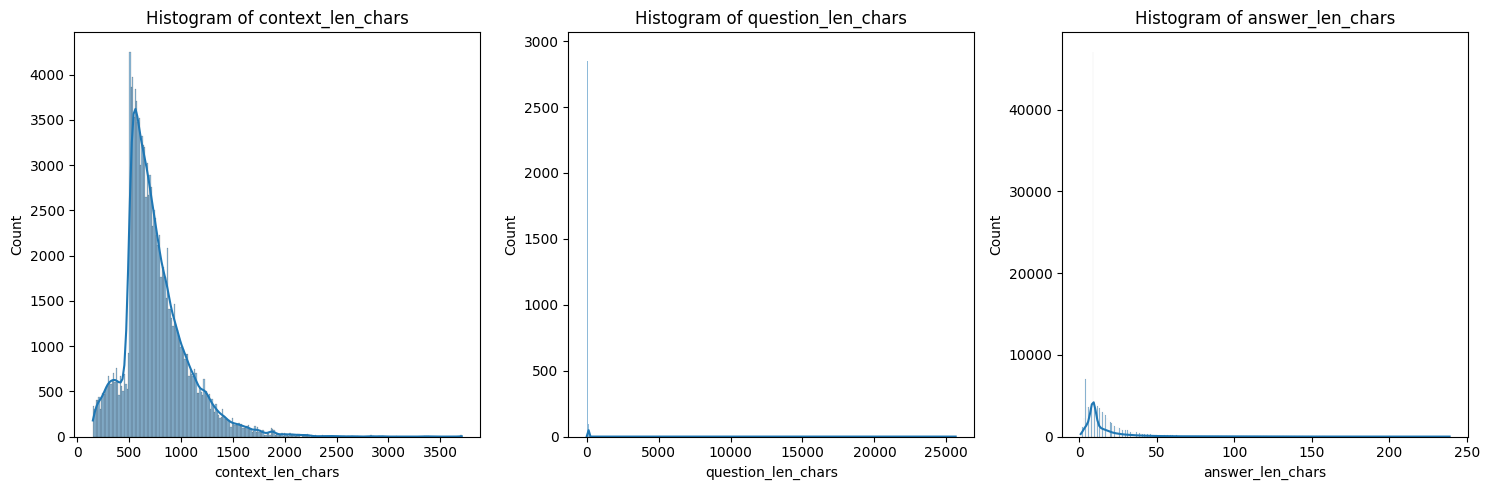

In [ ]:
df['context_len_chars'] = df['context'].apply(len)
df['question_len_chars'] = df['question'].apply(len)
df['answer_len_chars'] = df['answer'].apply(len)

cols_chars = ['context_len_chars', 'question_len_chars', 'answer_len_chars']
plt.figure(figsize=(15, 5))
for i, col in enumerate(cols_chars, 1):
    plt.subplot(1, 3, i)
    plt.title(f'Histogram of {col}')
    sns.histplot(df[col], kde=True)
plt.tight_layout()
plt.show()


In [ ]:
duplicate_questions = df['question'].duplicated().sum()
print("Number of duplicate questions:", duplicate_questions)


Number of duplicate questions: 102


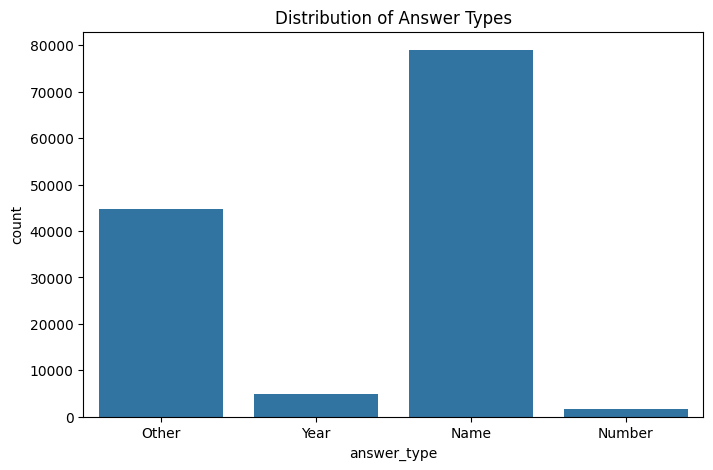

In [ ]:
import re

def classify_answer(answer):
    if re.match(r'^\d{4}$', answer):  # matches a year
        return 'Year'
    elif re.match(r'^\d+$', answer):
        return 'Number'
    elif re.match(r'^[A-Z].*', answer):
        return 'Name'
    else:
        return 'Other'

df['answer_type'] = df['answer'].apply(classify_answer)
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='answer_type')
plt.title('Distribution of Answer Types')
plt.show()


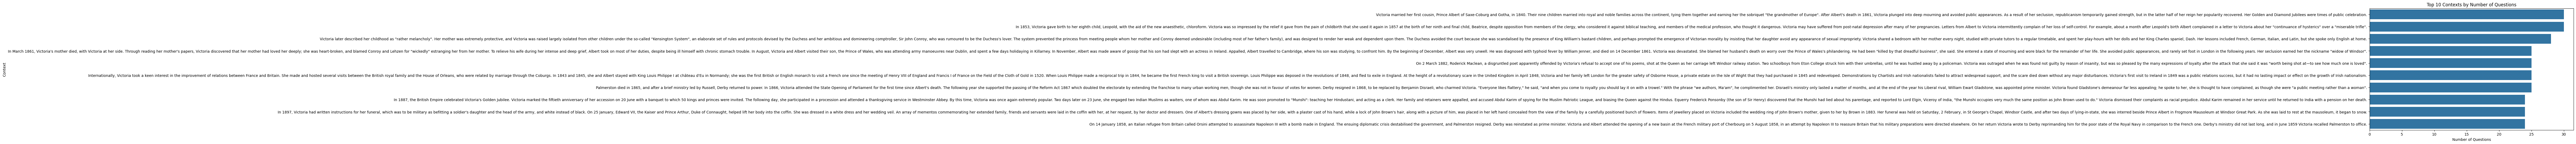

In [ ]:
top_contexts = df['context'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_contexts.values, y=top_contexts.index)
plt.title('Top 10 Contexts by Number of Questions')
plt.xlabel('Number of Questions')
plt.ylabel('Context')
plt.show()


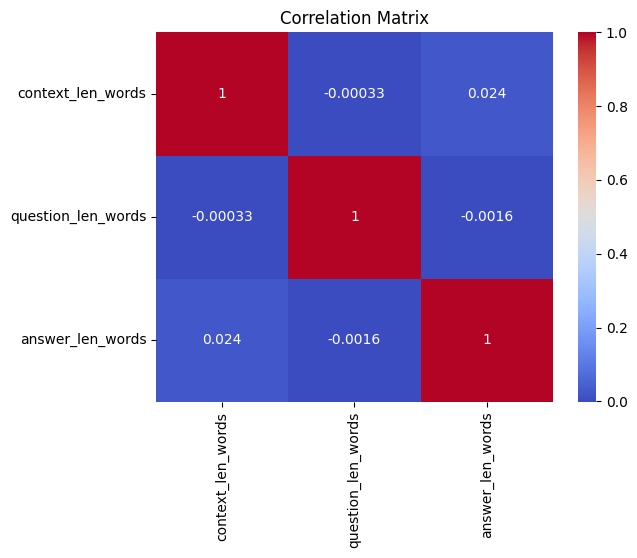

In [ ]:
corr_cols = ['context_len_words', 'question_len_words', 'answer_len_words']
corr_matrix = df[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
path = Path('squad/train-v2.0.json')

with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                texts.append(context)
                queries.append(question)
                answers.append(answer)

train_texts, train_queries, train_answers = texts, queries, answers

In [ ]:
path = Path('squad/dev-v2.0.json')

with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                texts.append(context)
                queries.append(question)
                answers.append(answer)

val_texts, val_queries, val_answers = texts, queries, answers

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', 30)
pd.set_option('display.width', 1000)

data = {
    "Passage": train_texts[:10],
    "Query": train_queries[:10],
    "Answer": [answer['text'] for answer in train_answers[:10]]
}

df = pd.DataFrame(data)

print(df)


                         Passage                          Query               Answer
0  Beyoncé Giselle Knowles-Ca...  When did Beyonce start bec...    in the late 1990s
1  Beyoncé Giselle Knowles-Ca...  What areas did Beyonce com...  singing and dancing
2  Beyoncé Giselle Knowles-Ca...  When did Beyonce leave Des...                 2003
3  Beyoncé Giselle Knowles-Ca...  In what city and state did...       Houston, Texas
4  Beyoncé Giselle Knowles-Ca...  In which decade did Beyonc...           late 1990s
5  Beyoncé Giselle Knowles-Ca...  In what R&B group was she ...      Destiny's Child
6  Beyoncé Giselle Knowles-Ca...  What album made her a worl...  Dangerously in Love
7  Beyoncé Giselle Knowles-Ca...  Who managed the Destiny's ...       Mathew Knowles
8  Beyoncé Giselle Knowles-Ca...  When did Beyoncé rise to f...           late 1990s
9  Beyoncé Giselle Knowles-Ca...  What role did Beyoncé have...          lead singer


In [ ]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

86821
86821
86821


In [ ]:
print("Passage: ",train_texts[0])
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


In [ ]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))


20302
20302
20302


In [ ]:
print("Passage: ",val_texts[0])
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Query:  In what country is Normandy located?
Answer:  {'text': 'France', 'answer_start': 159}


<h1> Find End Position Character </h1>

In [ ]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

<h1> Tokenizing passages and queries</h1>


In [ ]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<h1>Convert the start-end positions to tokens start-end positions</h1>

In [ ]:

def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  count = 0

  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length

    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

10
16


<h1> Dataset class </h1>

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

<h1>Using DataLoader</h1>


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

<h1>Building BERT Model<h1>

In [ ]:

import torch
from transformers import BertForQuestionAnswering, AdamW

model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)

epochs = 3


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<h1>Training and Evaluating the Models

In [ ]:
import time

whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
  epoch_time = time.time()

  # Set model in train mode
  model.train()

  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader):

    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # do a backwards pass
    loss.backward()
    # update the weights
    optim.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  ##########Evaluation##################

  # Set model in evaluation mode
  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(val_loader):

    with torch.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      # Find the total loss
      loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)

  # Print each epoch's time and train/val loss
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 1000 / 43411 
Loss: 3.1 

Batch 2000 / 43411 
Loss: 0.9 

Batch 3000 / 43411 
Loss: 1.7 

Batch 4000 / 43411 
Loss: 1.3 

Batch 5000 / 43411 
Loss: 2.3 

Batch 6000 / 43411 
Loss: 0.9 

Batch 7000 / 43411 
Loss: 2.1 

Batch 8000 / 43411 
Loss: 0.4 

Batch 9000 / 43411 
Loss: 1.0 

Batch 10000 / 43411 
Loss: 0.6 

Batch 11000 / 43411 
Loss: 3.8 

Batch 12000 / 43411 
Loss: 4.6 

Batch 13000 / 43411 
Loss: 1.3 

Batch 14000 / 43411 
Loss: 2.3 

Batch 15000 / 43411 
Loss: 3.5 

Batch 16000 / 43411 
Loss: 0.7 

Batch 17000 / 43411 
Loss: 2.1 

Batch 18000 / 43411 
Loss: 1.3 

Batch 19000 / 43411 
Loss: 2.2 

Batch 20000 / 43411 
Loss: 1.6 

Batch 21000 / 43411 
Loss: 2.4 

Batch 22000 / 43411 
Loss: 1.2 

Batch 23000 / 43411 
Loss: 1.3 

Batch 24000 / 43411 
Loss: 1.4 

Batch 25000 / 43411 
Loss: 1.2 

Batch 26000 / 43411 
Loss: 1.4 

Batch 27000 / 43411 
Loss: 2.1 

Batch 28000 / 43411 
Loss: 2.7 

Batch 29000 / 43411 
Loss: 0.1 

Batch 30000 / 43411 
L

<h1>Initialize XLNet Tokenizer and Model</h1>

In [ ]:
from transformers import XLNetTokenizer, XLNetForQuestionAnswering

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

model = XLNetForQuestionAnswering.from_pretrained('xlnet-base-cased').to(device)


In [ ]:
train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True, return_tensors='pt')

<h1>Convert Character Positions to Token Positions</h1>

In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []

    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length

        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
            if end_positions[-1] is None:
                end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)


<h1>Train and Evaluate the Model</h1>

In [ ]:
# Initialize optimizer
optim = AdamW(model.parameters(), lr=5e-5)

# Training and Evaluation Loop
epochs = 3
train_losses = []
val_losses = []
print_every = 1000

for epoch in range(epochs):
    epoch_time = time.time()
    model.train()
    loss_of_epoch = 0
    print("############Train############")

    for batch_idx, batch in enumerate(train_loader):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        loss.backward()
        optim.step()
        loss_of_epoch += loss.item()

        if (batch_idx + 1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx + 1, len(train_loader)), "\nLoss:", round(loss.item(), 1), "\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    model.eval()
    print("############Evaluate############")
    loss_of_epoch = 0

    for batch_idx, batch in enumerate(val_loader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs.loss
            loss_of_epoch += loss.item()

        if (batch_idx + 1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx + 1, len(val_loader)), "\nLoss:", round(loss.item(), 1), "\n")

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    print("\n-------Epoch ", epoch + 1, "-------"
          "\nTraining Loss:", train_losses[-1],
          "\nValidation Loss:", val_losses[-1],
          "\nTime: ", (time.time() - epoch_time),
          "\n-----------------------", "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))
